In [28]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time


sys.path.insert(1, '../../Modeles2D/test_premier_model/')
# hand made functions
from Rouss1 import *
from Rouss2 import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

sys.path.insert(1, '../test_3D/')
# hand made functions for 3D models
from Rouss3D import *


In [29]:
model_dir = "working"
model_name = "test_3D"
exe_name= "../../exe/mf6"

In [30]:
#geo parameters

MNT_path = "../../data/MNT/MNT_50.tif"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

Lx = x1-x0
Ly = y1-y0
nlay = 3
res = 300

ncol = int(Lx/res)
nrow = int(Ly/res)

delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

In [31]:
# load differents surfaces

folder_path = "../../data/txt_couches_nouv"
surfaces = []
for file in glob.glob(os.path.join(folder_path, '*.txt')):
    Rast = Raster.load(file)
    surfaces.append(Rast.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Rast.bands[0],
                                method="nearest"))

top = surfaces[0]
Q = surfaces[1]
PC = surfaces[2]
PMS = surfaces[3]

In [32]:
#domain
idomain = np.zeros([nlay,nrow,ncol])

for ilay in range(nlay):
    idomain[ilay] = active_dom(surfaces[ilay+1],grid)

In [33]:
#surfaces
botm = np.zeros([nlay,nrow,ncol])
min_ep = 10

bot_surf = top.copy() # a list that will contain infos about the bottom of a surface, update at each loop
for ilay in range(nlay):
    
    bot_surf[idomain[ilay] != 1] -= 1 # --> bot_surf - 1
    bot_surf[idomain[ilay] == 1] = surfaces[ilay+1][idomain[ilay] == 1] # where idomain for ilay is active --> bot_surf take the values of the surface

    botm[ilay] = bot_surf

# change top of active cells with negative thickness or below a certain thickness m
for ilay in range(nlay-1):
    mask = ((botm[ilay] - botm[ilay+1])< min_ep) & (idomain[ilay+1]==1)
    botm[ilay][mask] = botm[ilay+1][mask] + min_ep

mask = ((top-botm[0])<=0) & (idomain[0]==1)
top[mask] = botm[0][mask] + min_ep

In [34]:
botm[botm<-1000]=0
top[top<-1000]=10

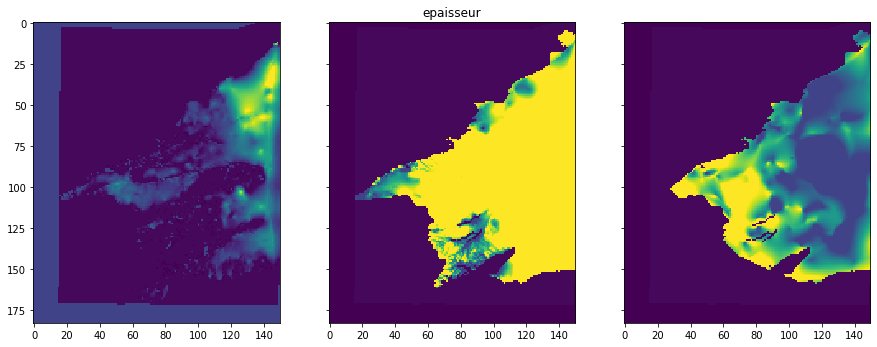

In [35]:
surf = [top,botm[0],botm[1],botm[2]]
fig,ax = plt.subplots(1,3,sharey=True,figsize=(15,10))
i=0;l=0
for s in np.arange(len(surf)-1):
    b=ax[i].imshow(surf[s]-surf[s+1])
    b.set_clim(0,50)
    ax[1].set_title("epaisseur")
    i +=1



In [36]:
write_pickle("../test_3D/working/export_dis3D",[top,botm,idomain])